In [3]:
using TimeSeries
using DataFrames
using CSV
using Proj4
using DataFrames: head
import PyPlot; plt=PyPlot
using LaTeXStrings
plt.rc("figure", dpi=300.0)
plt.rc("figure", figsize=(12,8))
plt.rc("savefig", dpi=300.0)
plt.rc("text", usetex=true)
plt.rc("font", family="serif")
plt.rc("font", serif="Palatino")
data_dir = ".."
include(joinpath(data_dir, "src/preprocessing.jl"))
include(joinpath(data_dir, "src/utils.jl"))
;

In [4]:
isdList=read_isdList(; data_dir=data_dir)
isdSubset=isdList[[(usaf in (725450,725460,725480,725485)) for usaf in isdList[:USAF]],:]
hourly_cat=read_Stations(isdSubset; data_dir=data_dir)
TnTx_dict = Dict{Int, Dict{Hour, DataFrame}}()
for istation in 1:4
    TnTx_dict[istation] = Dict{Hour,DataFrame}()
    for hr in Hour(0):Hour(1):Hour(24)
        TnTx = test_data(hourly_cat, istation, hr)
        TnTx_dict[istation][hr] = TnTx
    end
end
        
waterloo = hourly_cat[hourly_cat[:station].==3,:]
waterloo_TnTx_dict = TnTx_dict[3]
;

Stacktrace:
 [1] depwarn(::String, ::Symbol) at ./deprecated.jl:70
 [2] #readtable#233(::Bool, ::Char, ::Array{Char,1}, ::Char, ::Array{String,1}, ::Array{String,1}, ::Array{String,1}, ::Bool, ::Int64, ::Array{Symbol,1}, ::Array{Any,1}, ::Bool, ::Char, ::Bool, ::Int64, ::Array{Int64,1}, ::Bool, ::Symbol, ::Bool, ::Bool, ::DataFrames.#readtable, ::String) at /Users/imolk/Library/Julia/packages_experimental/v0.6/DataFrames/src/deprecated.jl:1050
 [3] readtable(::String) at /Users/imolk/Library/Julia/packages_experimental/v0.6/DataFrames/src/deprecated.jl:1050
 [4] #read_isdList#6(::String, ::Function) at /Users/imolk/Documents/Harvard/Natesh/temperature_model/src/preprocessing.jl:31
 [5] (::#kw##read_isdList)(::Array{Any,1}, ::#read_isdList) at ./<missing>:0
 [6] include_string(::String, ::String) at /Users/imolk/bin/julia_v0.6.2_binary/lib/julia/sys.dylib:?
 [7] include_string(::Module, ::String, ::String) at /Users/imolk/Library/Julia/packages_experimental/v0.6/Compat/src/Compat.jl:71


In [5]:
begin
    hr = Hour(23)
    low = Hour(8)
    peak = Hour(20)
    TnTx_low = waterloo_TnTx_dict[low]
    TnTx_peak = waterloo_TnTx_dict[peak]
    
    apr3_low = TnTx_low[TnTx_low[:ts_day].==DateTime(2015,4,4),:]
    apr3_peak = TnTx_peak[TnTx_peak[:ts_day].==DateTime(2015,4,4),:]
    
    global apr3_realmax = apr3_low[1,:Tx]
    global apr3_measured = apr3_peak[1,:Tx]
    println(apr3_realmax)
    println(apr3_measured)
end

7.2
15.6


In [6]:
iowa_time(ts) = ts - Hour(6)
iowa_time(waterloo[:ts][1])

2014-12-31T18:00:00

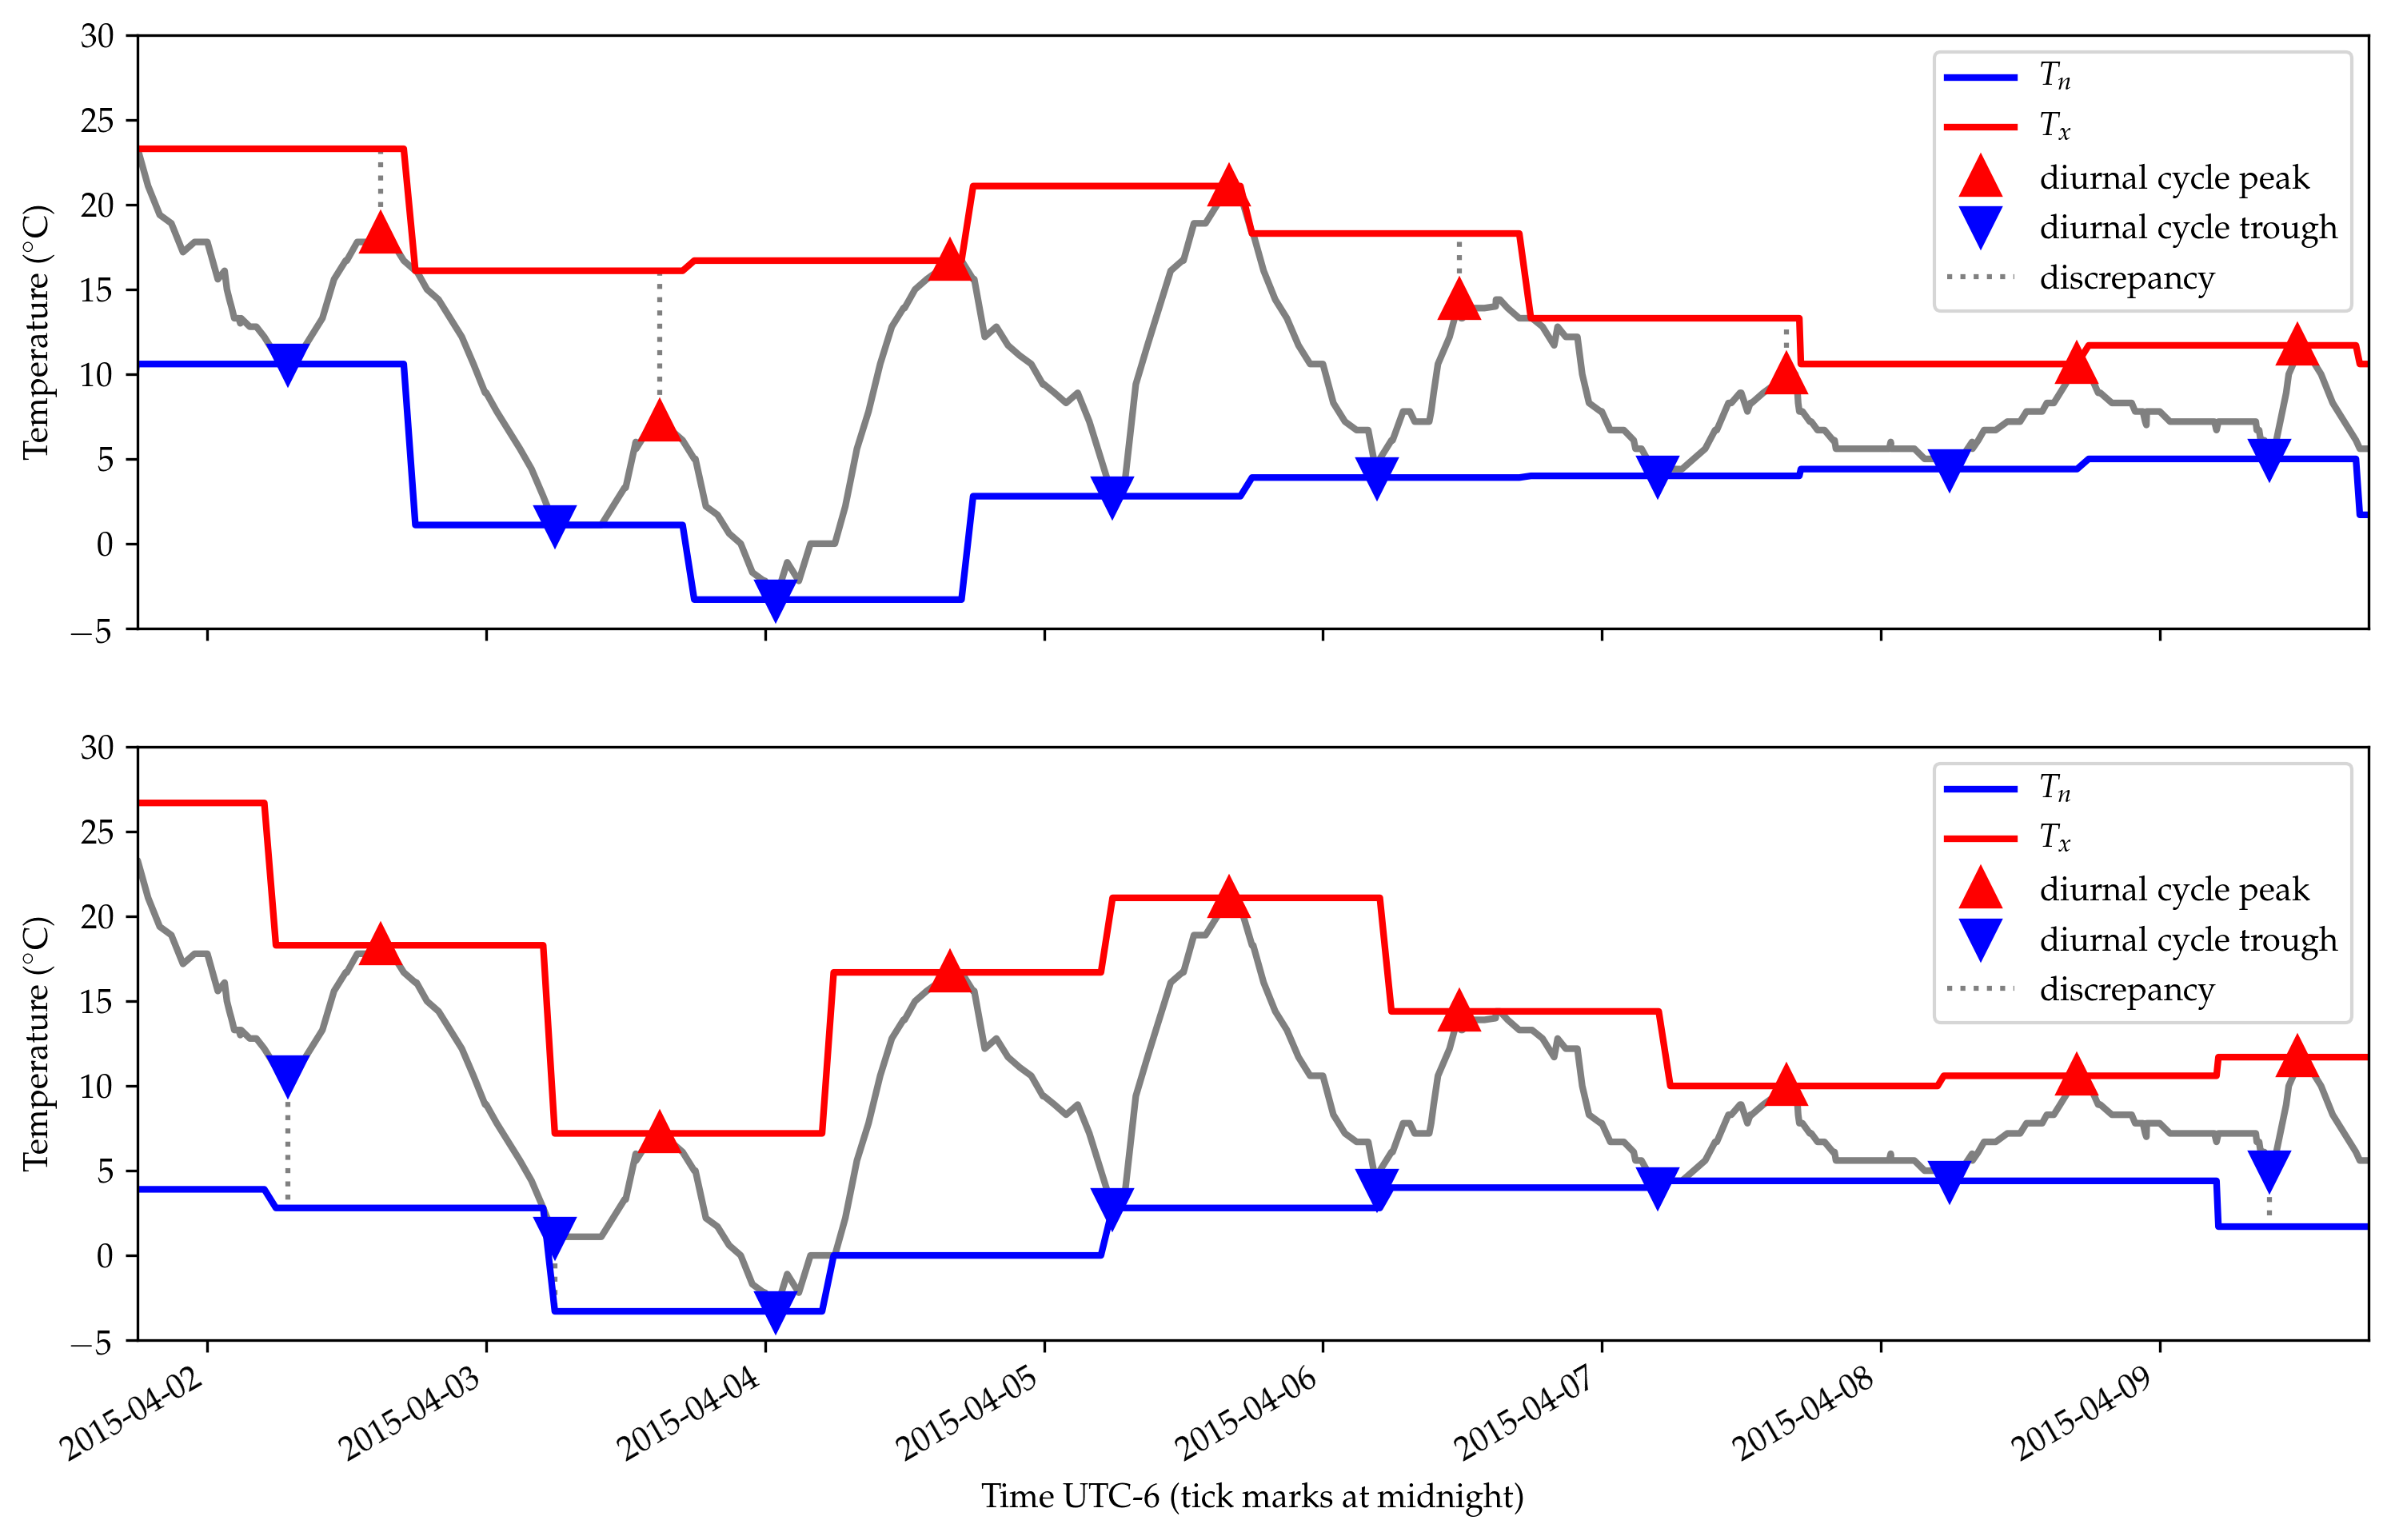

In [7]:
datemin = DateTime(2015,4,2)
datemax = DateTime(2015,4,10)
plt.subplot(2,1,1)
begin
    hr = Hour(17)+Hour(6)
    peak = Hour(14)+Hour(6)
    low = Hour(2)+Hour(6)
    waterloo[:ts_day] = [measurement_date(t,hr) for t in waterloo[:ts]]
    test_trimmed = join(waterloo, waterloo_TnTx_dict[hr], on=:ts_day)
    ts_hr = test_trimmed[:ts]
    inwindow = ((datemin-Day(1)) .< ts_hr) .& (ts_hr .< (datemax+Day(1)))
    plt.plot(
            iowa_time.(ts_hr[inwindow]), 
            test_trimmed[:temp][inwindow], 
            color="grey", linewidth=2)
    tn_hr = test_trimmed[:Tn]
    plt.plot(
            iowa_time.(ts_hr[inwindow]), 
            tn_hr[inwindow], 
            color="blue", linewidth=2, label=L"$T_n$")
    tx_hr = test_trimmed[:Tx]
    plt.plot(
            iowa_time.(ts_hr[inwindow]),
            tx_hr[inwindow], 
            color="red", linewidth=2, label=L"$T_x$")
    
    TnTx_low = waterloo_TnTx_dict[low]
    TnTx_peak = waterloo_TnTx_dict[peak]
    plt.plot(
        iowa_time.(TnTx_low[:Tx_time]),
        TnTx_low[:Tx], 
        linestyle="",
        marker="^", 
        color="red", 
        markeredgewidth=2,
        markersize=10,
        label="diurnal cycle peak"
        )
    plt.plot(
        iowa_time.(TnTx_peak[:Tn_time]),
        TnTx_peak[:Tn], 
        linestyle="",
        marker="v", 
        color="blue", 
        markeredgewidth=2,
        markersize=10,
        label="diurnal cycle trough"
        )
    labeled_disc = false
    for i in 1:size(TnTx_low, 1)
        txtime = TnTx_low[:Tx_time][i]
        tx_low = TnTx_low[:Tx][i]
        its = searchsortedfirst(ts_hr, txtime)
        tx_obs = tx_hr[its]
        if tx_low != tx_obs
            if labeled_disc
                label = ""
            else
                label = "discrepancy"
                labeled_disc = true
            end
            plt.plot(iowa_time.([txtime, txtime]), (tx_low, tx_obs), ":", color="grey", 
                     zorder=-1, label=label)
        end
    end
    for i in 1:size(TnTx_peak, 1)
        tntime = TnTx_peak[:Tn_time][i]
        tn_low = TnTx_peak[:Tn][i]
        its = searchsortedfirst(ts_hr, tntime)
        tn_obs = tn_hr[its]
        if tn_low != tn_obs
            if labeled_disc
                label = ""
            else
                label = "discrepancy"
                labeled_disc = true
            end
            plt.plot(iowa_time.([tntime, tntime]), (tn_low, tn_obs), ":", color="grey", 
                     zorder=-1, label=label)
        end
    end
    plt.xlim(iowa_time.([datemin, datemax])) # random interval
    plt.ylim(-5,30)
    plt.ylabel(L"Temperature ($^{\circ}$C)")
    plt.legend()
end
plt.gca()[:set_xticklabels]([])
plt.subplot(2,1,2)
begin
    hr = Hour(5)+Hour(6)
    peak = Hour(14)+Hour(6)
    low = Hour(2)+Hour(6)
    waterloo[:ts_day] = [measurement_date(t,hr) for t in waterloo[:ts]]
    test_trimmed = join(waterloo, waterloo_TnTx_dict[hr], on=:ts_day)
    ts_hr = test_trimmed[:ts]
    inwindow = ((datemin-Day(1)) .< ts_hr) .& (ts_hr .< (datemax+Day(1)))
    plt.plot(
            iowa_time.(ts_hr[inwindow]), 
            test_trimmed[:temp][inwindow], 
            color="grey", linewidth=2)
    tn_hr = test_trimmed[:Tn]
    plt.plot(
            iowa_time.(ts_hr[inwindow]), 
            tn_hr[inwindow], 
            color="blue", linewidth=2, label=L"$T_n$")
    tx_hr = test_trimmed[:Tx]
    plt.plot(
            iowa_time.(ts_hr[inwindow]),
            tx_hr[inwindow], 
            color="red", linewidth=2, label=L"$T_x$")
    
    TnTx_low = waterloo_TnTx_dict[low]
    TnTx_peak = waterloo_TnTx_dict[peak]
    plt.plot(
        iowa_time.(TnTx_low[:Tx_time]),
        TnTx_low[:Tx], 
        linestyle="",
        marker="^", 
        color="red", 
        markeredgewidth=2,
        markersize=10,
        label="diurnal cycle peak"
        )
    plt.plot(
        iowa_time.(TnTx_peak[:Tn_time]),
        TnTx_peak[:Tn], 
        linestyle="",
        marker="v", 
        color="blue", 
        markeredgewidth=2,
        markersize=10,
        label="diurnal cycle trough"
        )
    labeled_disc = false
    for i in 1:size(TnTx_low, 1)
        txtime = TnTx_low[:Tx_time][i]
        tx_low = TnTx_low[:Tx][i]
        its = searchsortedfirst(ts_hr, txtime)
        tx_obs = tx_hr[its]
        if tx_low != tx_obs
            if labeled_disc
                label = ""
            else
                label = "discrepancy"
                labeled_disc = true
            end
            plt.plot(iowa_time.([txtime, txtime]), (tx_low, tx_obs), ":", color="grey", 
                     zorder=-1, label=label)
        end
    end
    for i in 1:size(TnTx_peak, 1)
        tntime = TnTx_peak[:Tn_time][i]
        tn_low = TnTx_peak[:Tn][i]
        its = searchsortedfirst(ts_hr, tntime)
        tn_obs = tn_hr[its]
        if tn_low != tn_obs
            if labeled_disc
                label = ""
            else
                label = "discrepancy"
                labeled_disc = true
            end
            plt.plot(iowa_time.([tntime, tntime]), (tn_low, tn_obs), ":", color="grey", 
                     zorder=-1, label=label)
        end
    end
    plt.xlim(iowa_time.([datemin, datemax])) # random interval
    plt.ylim(-5,30)
    plt.ylabel(L"Temperature ($^{\circ}$C)")
    plt.legend()
end
plt.xlabel("Time UTC-6 (tick marks at midnight)")
plt.gcf()[:autofmt_xdate]()
plt.savefig("../figures/waterloo_triangles.png", bbox_inches="tight")
plt.savefig("../figures/waterloo_triangles.pdf", bbox_inches="tight")

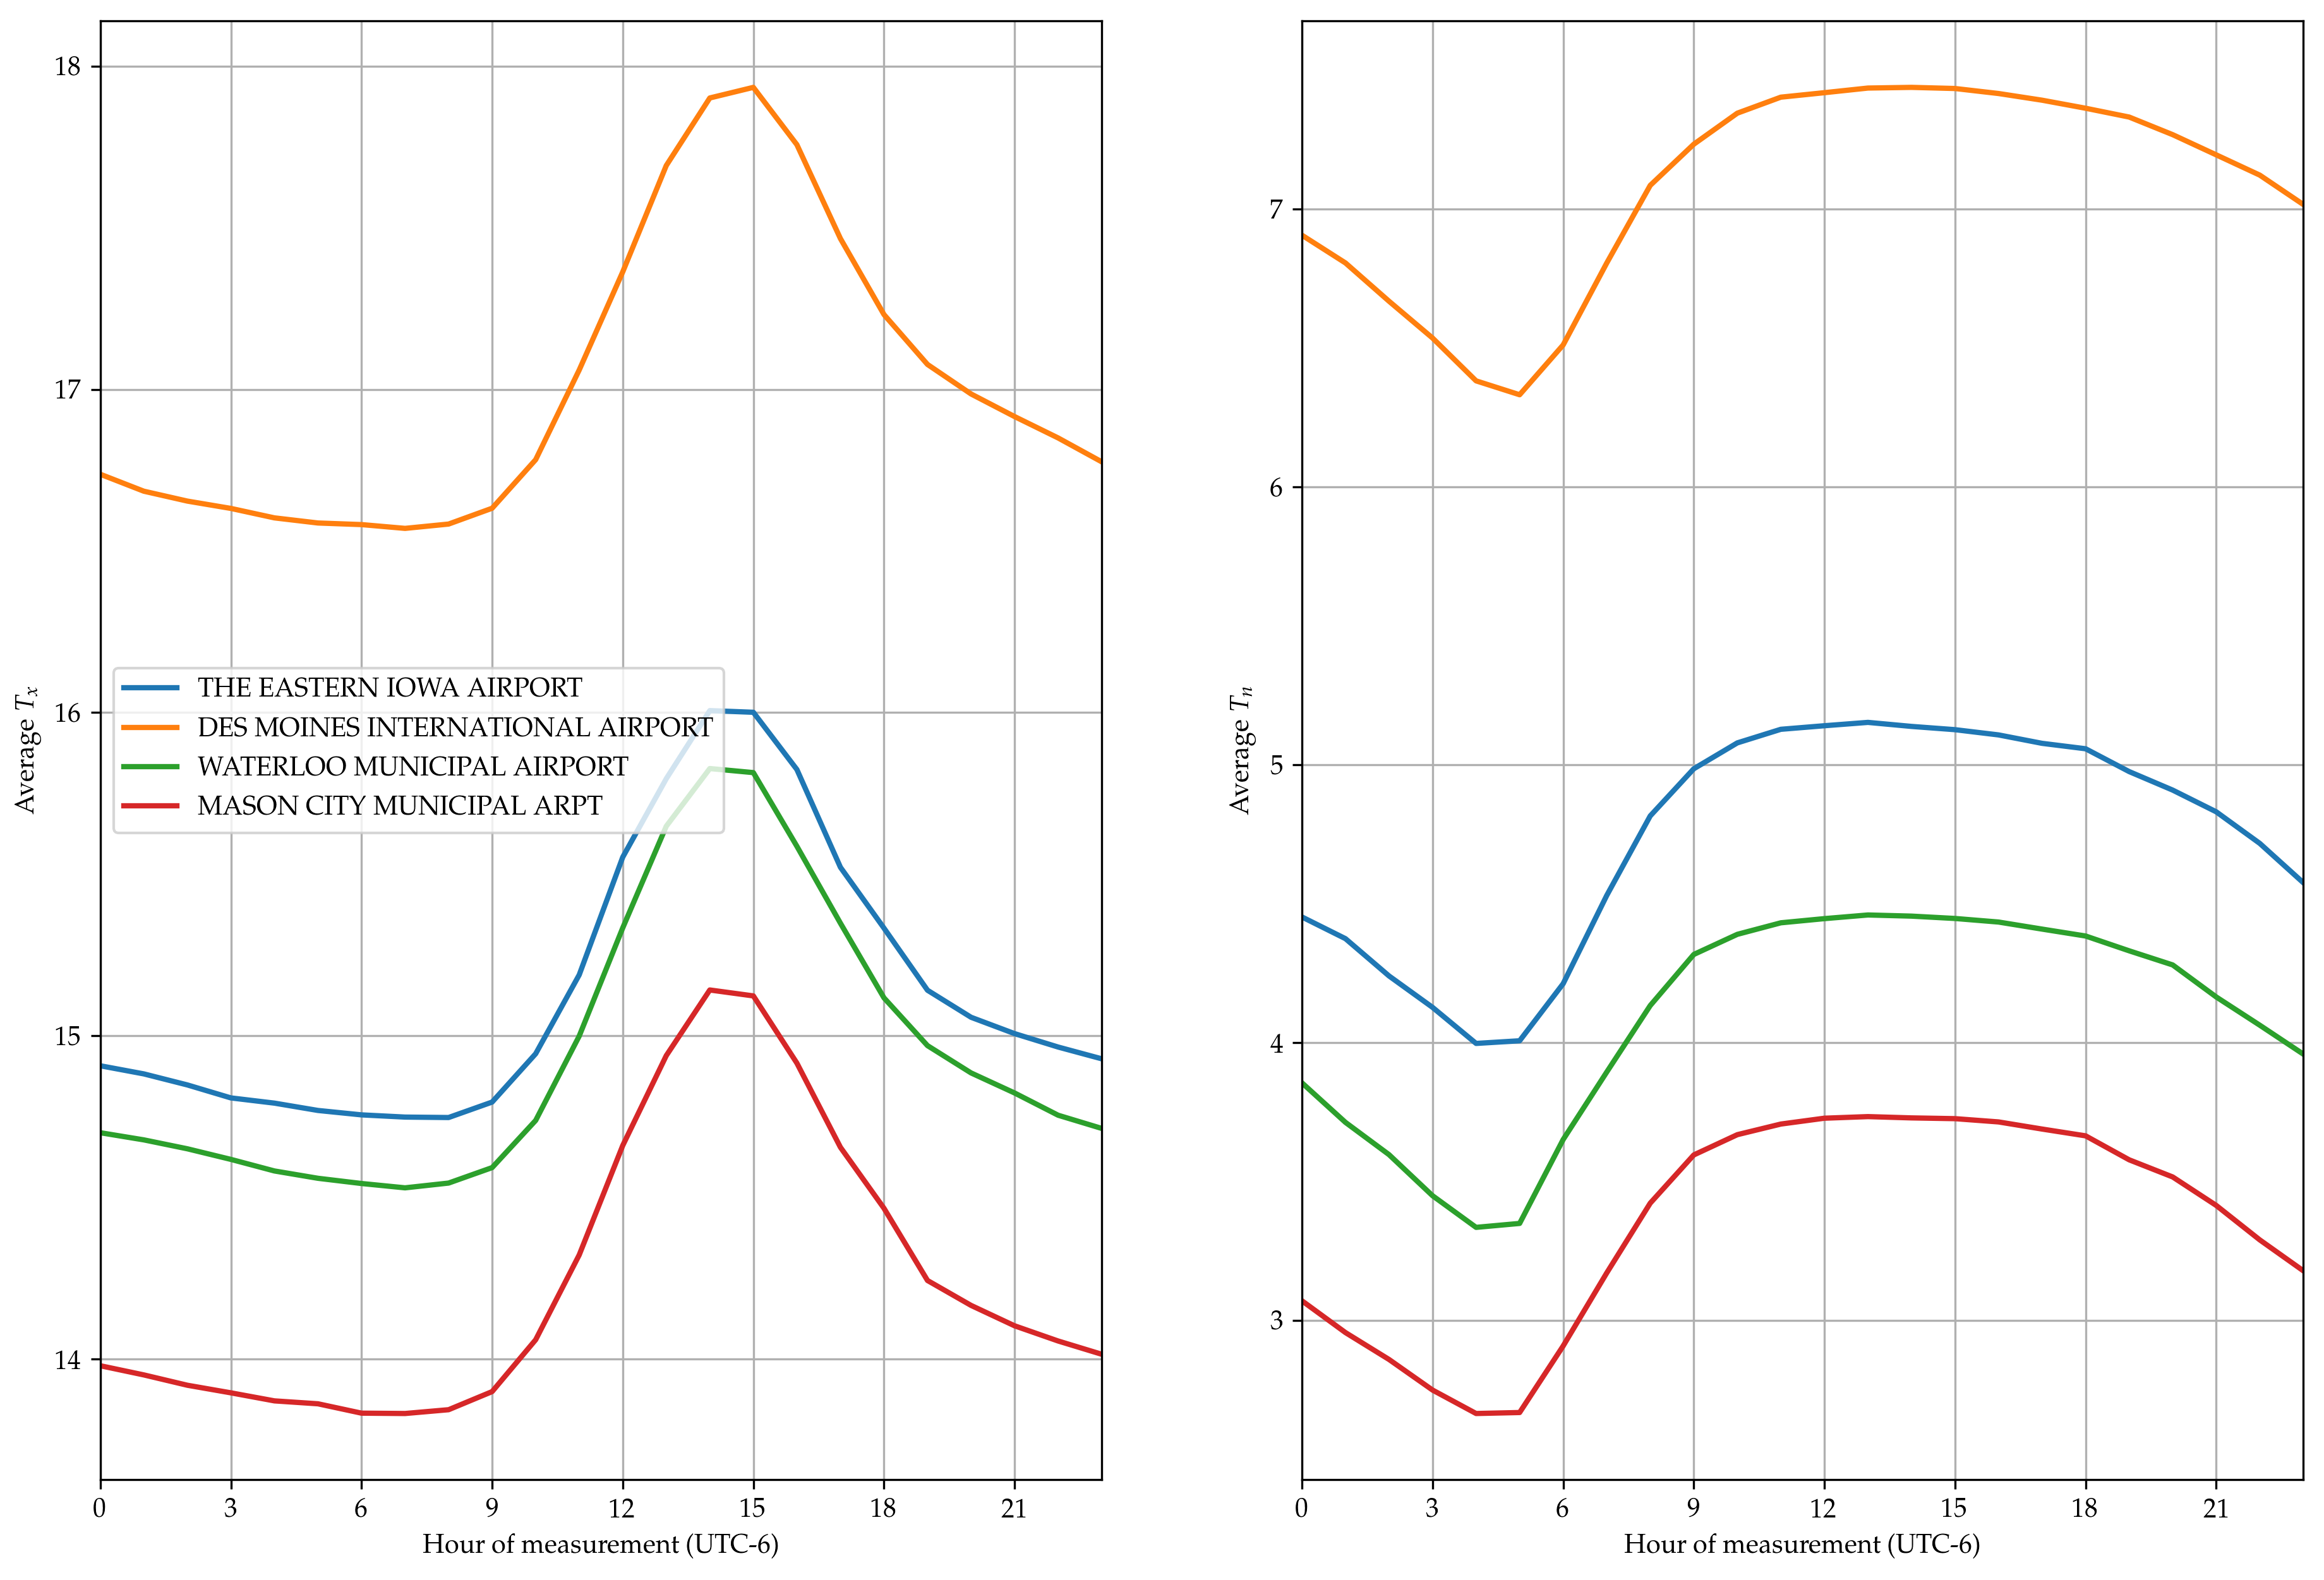

In [8]:
begin
plt.subplot(1,2,1)
hours = Hour(0):Hour(1):Hour(23)
ilocaltime = circshift(1:24, -6)
begin
    statdict = Dict{Int64, Vector{Float64}}(
        1=>Float64[],
        2=>Float64[],
        3=>Float64[],
        4=>Float64[]
        )
    for istation in 1:4
        for hr in Hour(0):Hour(1):Hour(24)
            TnTx = TnTx_dict[istation][hr]
            push!(statdict[istation], mean(TnTx[:Tx]))
        end
    end

    for station in 1:4
        plt.plot(0:23, statdict[station][ilocaltime], linewidth=2, label=isdSubset[station,:NAME])
    end
    plt.ylabel(L"Average $T_x$")
    plt.xlabel("Hour of measurement (UTC-6)")
#     plt.title("Average daily maximum in 2015 as a function of the measurement hour")
    plt.grid(true)
    plt.legend(loc="center left")
    plt.xticks(0:3:24)
    plt.xlim(0, 23)
end
plt.subplot(1,2,2)
begin
    statdict = Dict{Int64, Vector{Float64}}(
        1=>Float64[],
        2=>Float64[],
        3=>Float64[],
        4=>Float64[]
        )
    for istation in 1:4
        for hr in hours
            TnTx = TnTx_dict[istation][hr]
            push!(statdict[istation], mean(TnTx[:Tn]))
        end
    end

    for station in 1:4
        plt.plot(0:23, statdict[station][ilocaltime], linewidth=2, label=isdSubset[station,:NAME])
    end
    plt.ylabel(L"Average $T_n$")
    plt.xlabel("Hour of measurement (UTC-6)")
#     plt.title("Average daily minimum in 2015 as a function of the measurement hour")
    plt.grid(true)
    plt.xticks(0:3:24)
    plt.xlim(0, 23)
end
plt.gcf()[:set_size_inches](15.0, 10.0)
plt.savefig("../figures/waterloo_avgTnTx.png", bbox_inches="tight")
plt.savefig("../figures/waterloo_avgTnTx.pdf", bbox_inches="tight")
end;

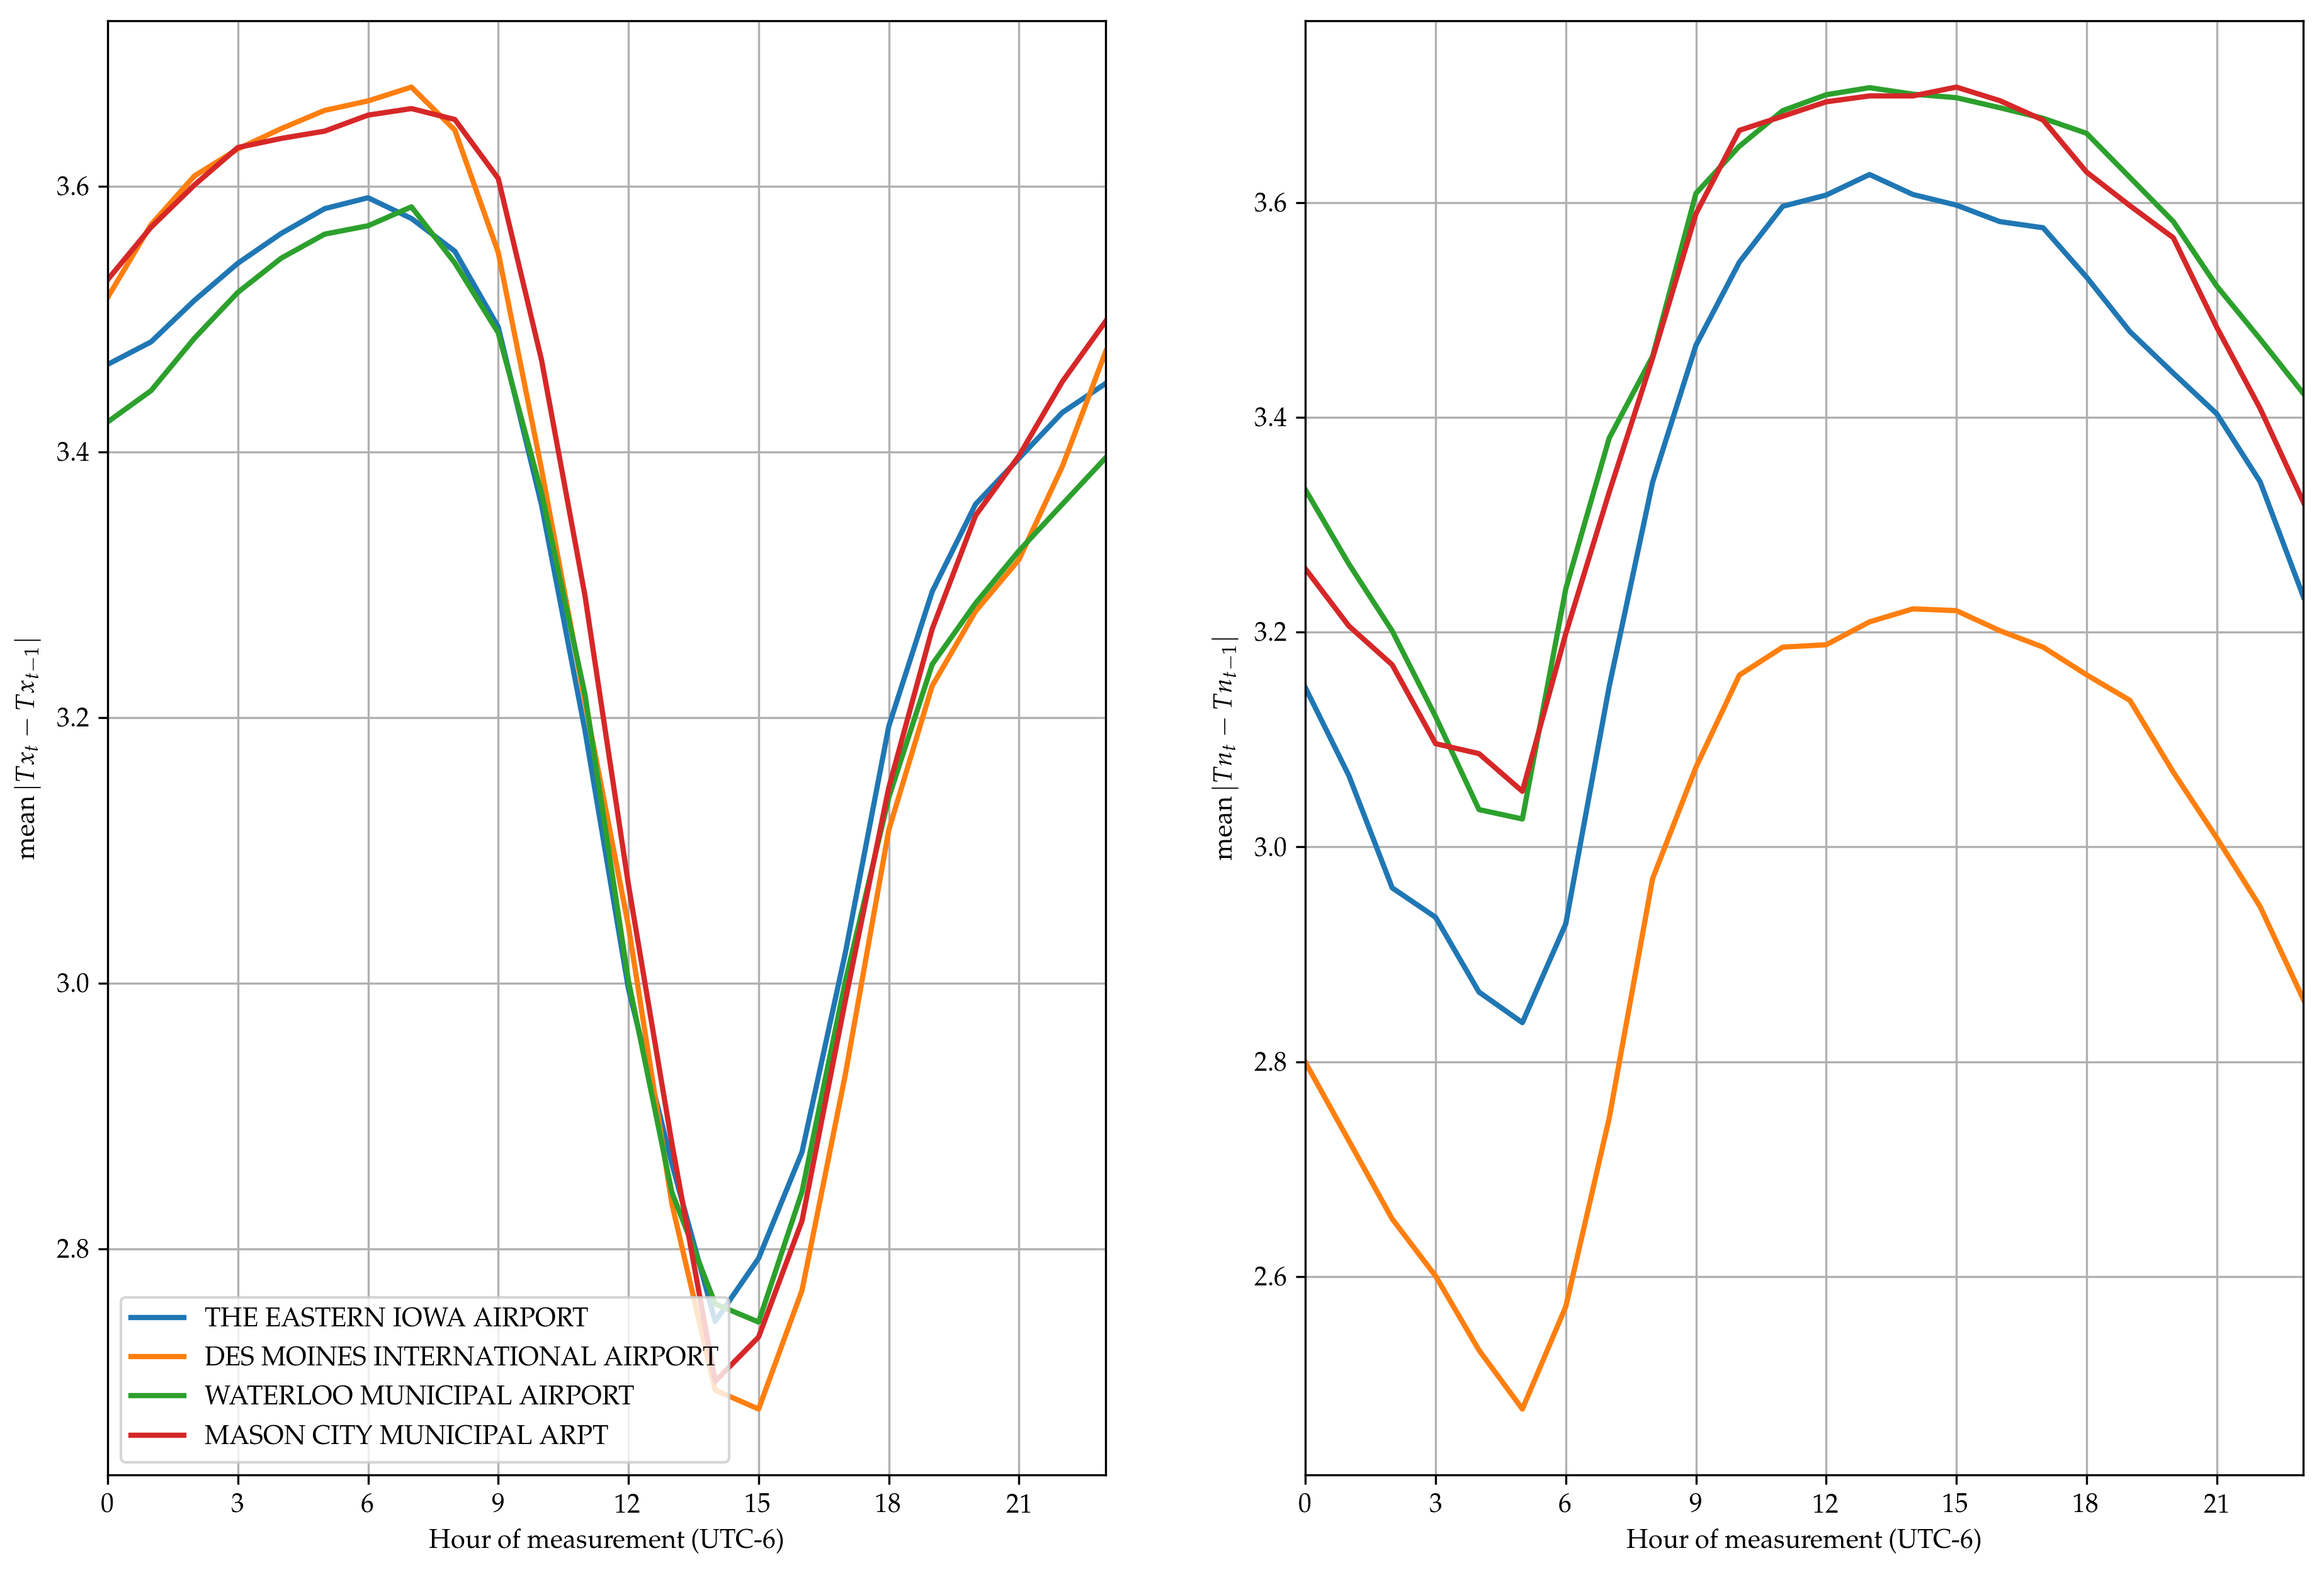

In [14]:
plt.subplot(1,2,1)
hours = Hour(0):Hour(1):Hour(23)
ilocaltime = circshift(1:24, -6)
begin
    meandiff = Dict{Int64, Vector{Float64}}(
        1=>Float64[],
        2=>Float64[],
        3=>Float64[],
        4=>Float64[]
        )
    for istation in 1:4
        for hr in hours
            TnTx = TnTx_dict[istation][hr]
            push!(meandiff[istation], mean(abs.(diff(TnTx[:Tx]))))
        end
    end

    for station in 1:4
        plt.plot(0:23, meandiff[station][ilocaltime], linewidth=2, label=isdSubset[station,:NAME])
    end
    plt.ylabel(L"$\mathrm{mean}\left| Tx_{t}-Tx_{t-1} \right|$")
#     plt.title("Mean absolute change in daily maximum temperature in 2015")
    plt.xlabel("Hour of measurement (UTC-6)")
    plt.grid()
    plt.legend(loc="lower left")
    plt.xticks(0:3:24)
    plt.xlim(0, 23)
end
plt.subplot(1,2,2)
begin
    meandiff = Dict{Int64, Vector{Float64}}(
        1=>Float64[],
        2=>Float64[],
        3=>Float64[],
        4=>Float64[]
        )
    for istation in 1:4
        for hr in hours
            TnTx = TnTx_dict[istation][hr]
            push!(meandiff[istation], mean(abs.(diff(TnTx[:Tn]))))
        end
    end

    for station in 1:4
        plt.plot(0:23, meandiff[station][ilocaltime], linewidth=2)
    end
    plt.ylabel(L"$\mathrm{mean}\left| Tn_{t}-Tn_{t-1} \right|$")
#     plt.title("Mean absolute change in daily minimum temperature in 2015")
    plt.xlabel("Hour of measurement (UTC-6)")
    plt.grid(true)
    plt.xticks(0:3:24)
    plt.xlim(0, 23)
end
plt.gcf()[:set_size_inches](15.0, 10.0)
plt.savefig("../figures/waterloo_meanabsdiff.png", bbox_inches="tight")
plt.savefig("../figures/waterloo_meanabsdiff.pdf", bbox_inches="tight")
;

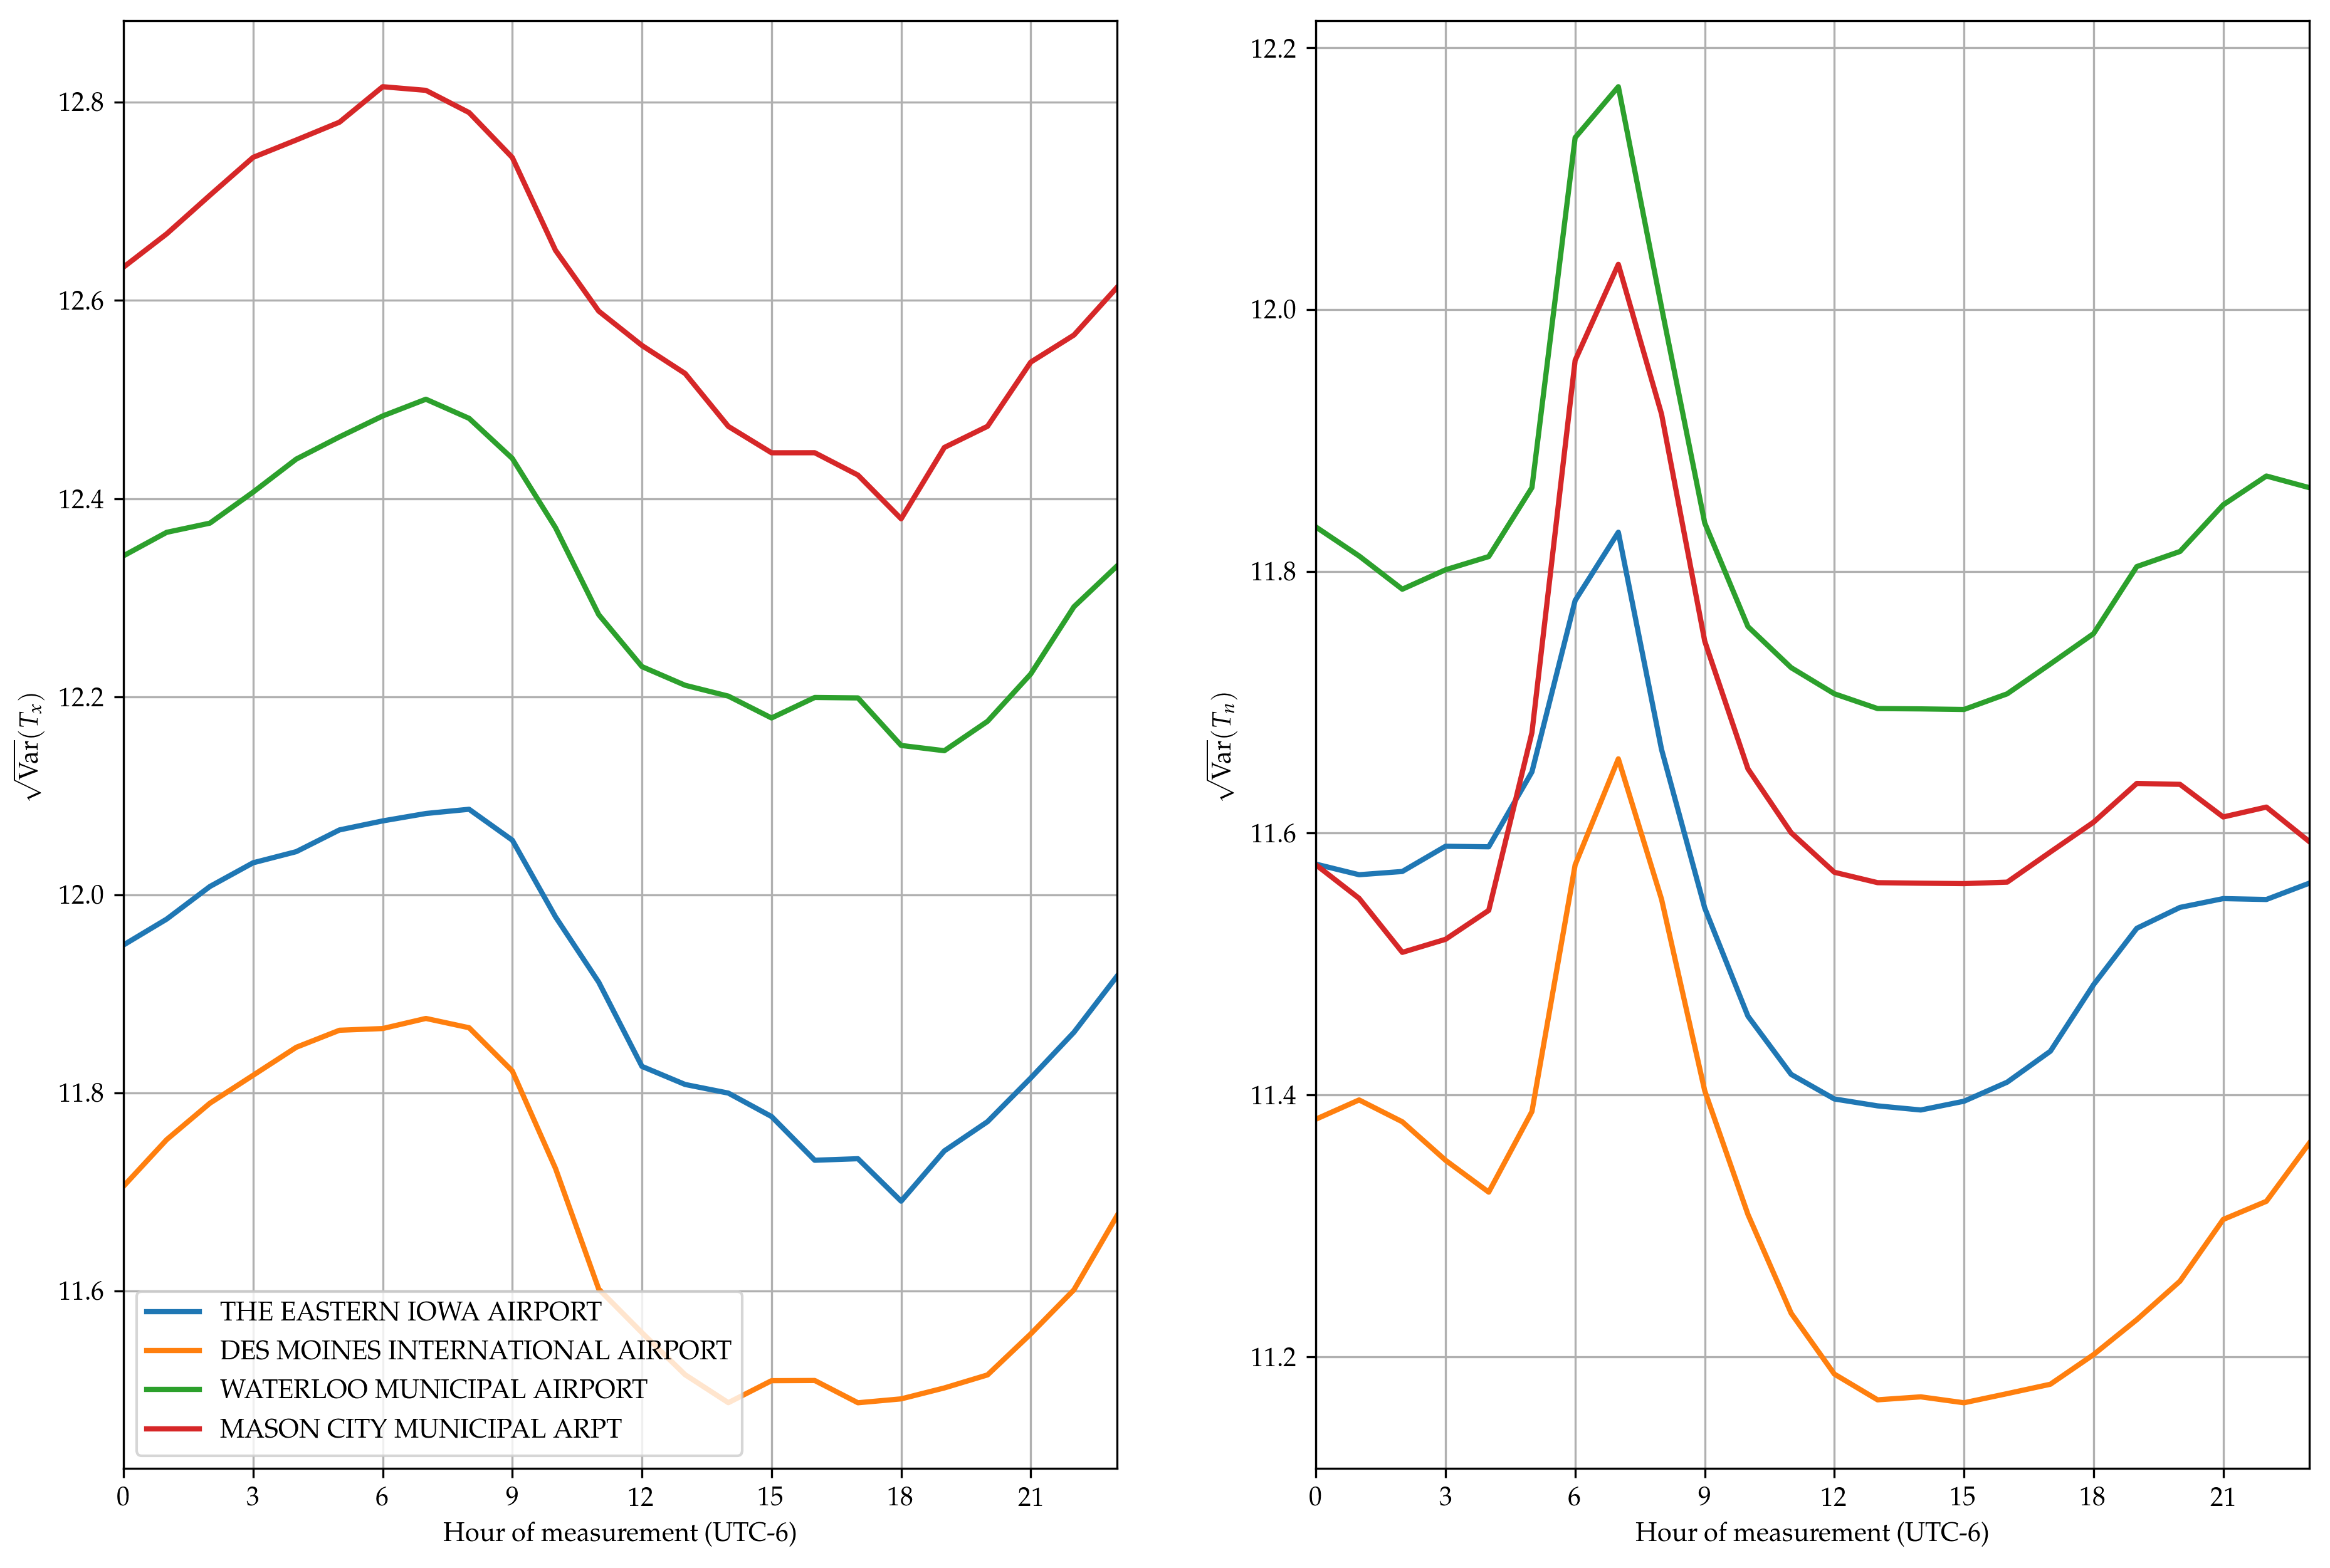

In [15]:
plt.subplot(1,2,1)
hours = Hour(0):Hour(1):Hour(23)
ilocaltime = circshift(1:24, -6)
begin
    statdict = Dict{Int64, Vector{Float64}}(
        1=>Float64[],
        2=>Float64[],
        3=>Float64[],
        4=>Float64[]
        )
    for istation in 1:4
        for hr in hours
            TnTx = TnTx_dict[istation][hr]
            push!(statdict[istation], var(TnTx[:Tx]))
        end
    end

    for station in 1:4
        plt.plot(0:23, sqrt.(statdict[station][ilocaltime]), linewidth=2, label=isdSubset[station,:NAME])
    end
    plt.ylabel(L"$\sqrt\mathrm{Var}(T_x)$")
    plt.xlabel("Hour of measurement (UTC-6)")
    plt.grid()
    plt.legend(loc="lower left")
    plt.xticks(0:3:24)
    plt.xlim(0, 23)
end
plt.subplot(1,2,2)
begin
    statdict = Dict{Int64, Vector{Float64}}(
        1=>Float64[],
        2=>Float64[],
        3=>Float64[],
        4=>Float64[]
        )
    for istation in 1:4
        for hr in hours
            TnTx = TnTx_dict[istation][hr]
            push!(statdict[istation], var(TnTx[:Tn]))
        end
    end

    for station in 1:4
        plt.plot(0:23, sqrt.(statdict[station][ilocaltime]), linewidth=2)
    end
    plt.ylabel(L"$\sqrt\mathrm{Var}(T_n)$")
    plt.xlabel("Hour of measurement (UTC-6)")
    plt.grid(true)
    plt.xticks(0:3:24)
    plt.xlim(0, 23)
end
plt.gcf()[:set_size_inches](15.0, 10.0)
plt.savefig("../figures/waterloo_var.png", bbox_inches="tight")
plt.savefig("../figures/waterloo_var.pdf", bbox_inches="tight")
;

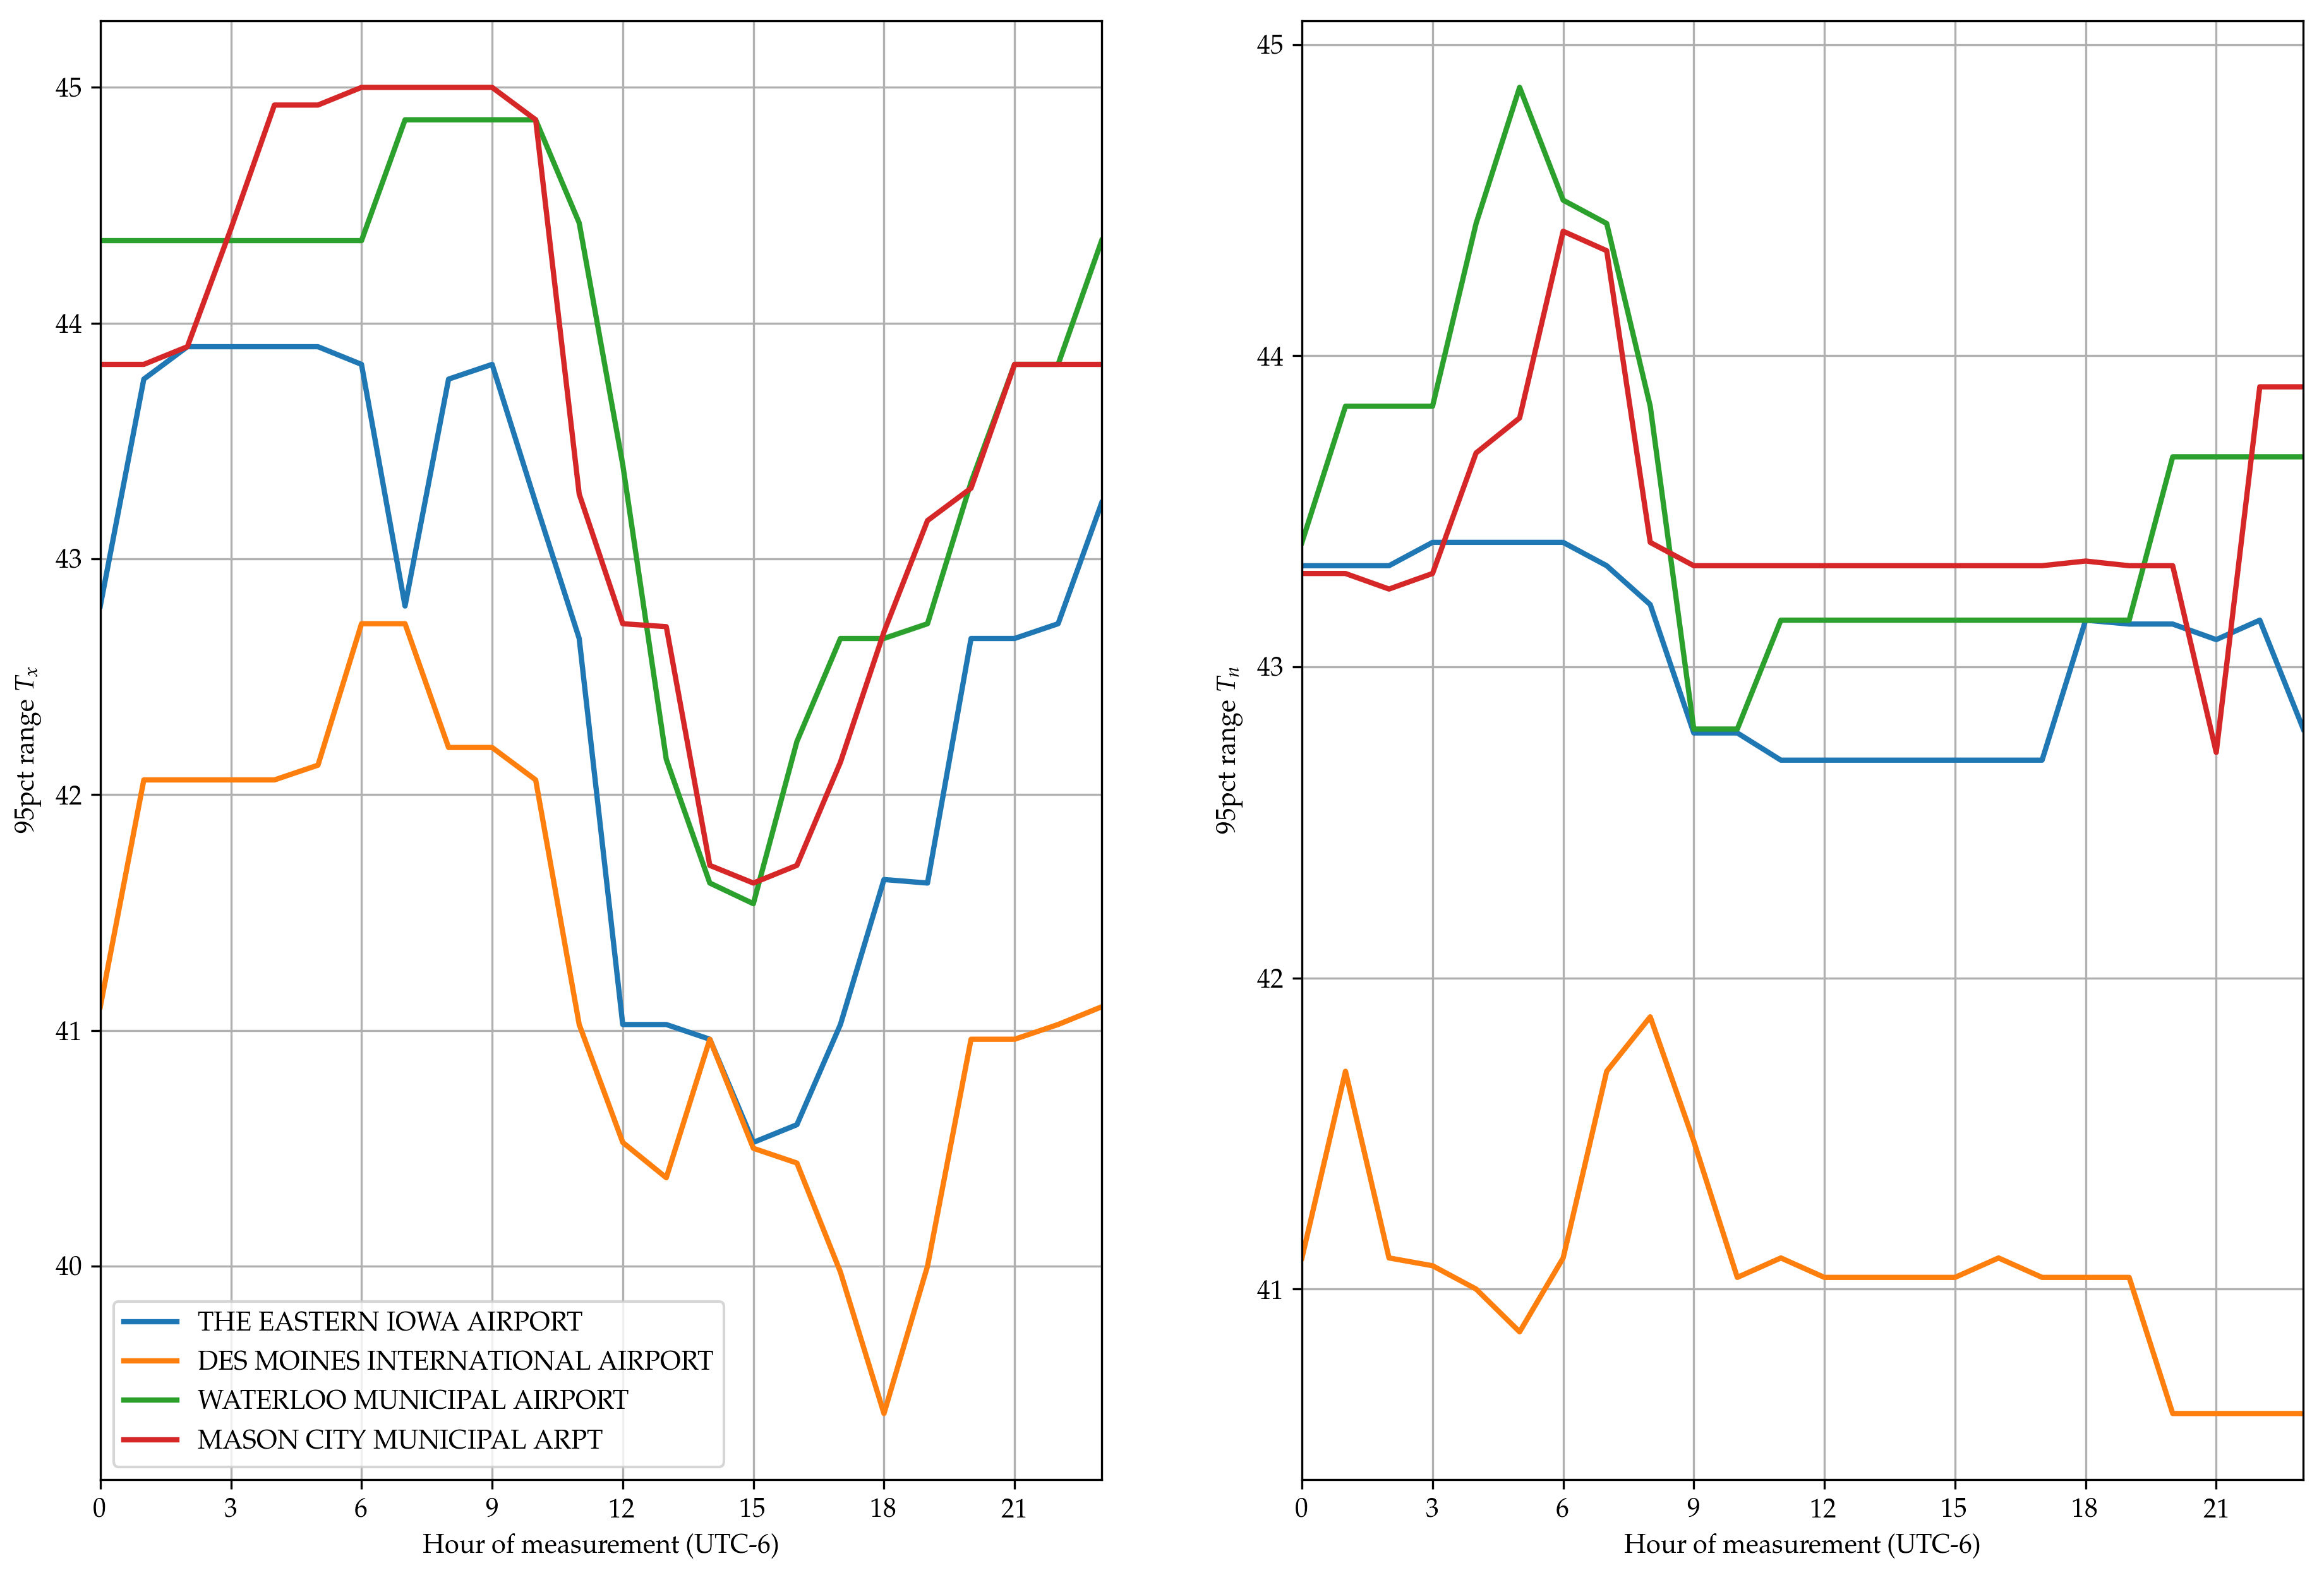

In [16]:
plt.subplot(1,2,1)
hours = Hour(0):Hour(1):Hour(23)
ilocaltime = circshift(1:24, -6)
begin
    statdict = Dict{Int64, Vector{Float64}}(
        1=>Float64[],
        2=>Float64[],
        3=>Float64[],
        4=>Float64[]
        )
    for istation in 1:4
        for hr in hours
            TnTx = TnTx_dict[istation][hr]
            y = TnTx[:Tx]
            perc975 = quantile(y, 0.975)
            perc025 = quantile(y, 0.025)
            push!(statdict[istation], perc975-perc025)
        end
    end

    for station in 1:4
        plt.plot(0:23, statdict[station][ilocaltime], linewidth=2, label=isdSubset[station,:NAME])
    end
    plt.ylabel(L"95pct range $T_x$")
    plt.xlabel("Hour of measurement (UTC-6)")
    plt.grid()
    plt.legend(loc="lower left")
    plt.xticks(0:3:24)
    plt.xlim(0, 23)
end
plt.subplot(1,2,2)
begin
    statdict = Dict{Int64, Vector{Float64}}(
        1=>Float64[],
        2=>Float64[],
        3=>Float64[],
        4=>Float64[]
        )
    for istation in 1:4
        for hr in hours
            TnTx = TnTx_dict[istation][hr]
            y = TnTx[:Tn]
            perc975 = quantile(y, 0.975)
            perc025 = quantile(y, 0.025)
            push!(statdict[istation], perc975-perc025)
        end
    end

    for station in 1:4
        plt.plot(0:23, statdict[station][ilocaltime], linewidth=2)
    end
    plt.ylabel(L"95pct range $T_n$")
    plt.xlabel("Hour of measurement (UTC-6)")
    plt.grid(true)
    plt.xticks(0:3:24)
    plt.xlim(0, 23)
end
plt.gcf()[:set_size_inches](15.0, 10.0)
plt.savefig("../figures/waterloo_95range.png", bbox_inches="tight")
plt.savefig("../figures/waterloo_95range.pdf", bbox_inches="tight")
;

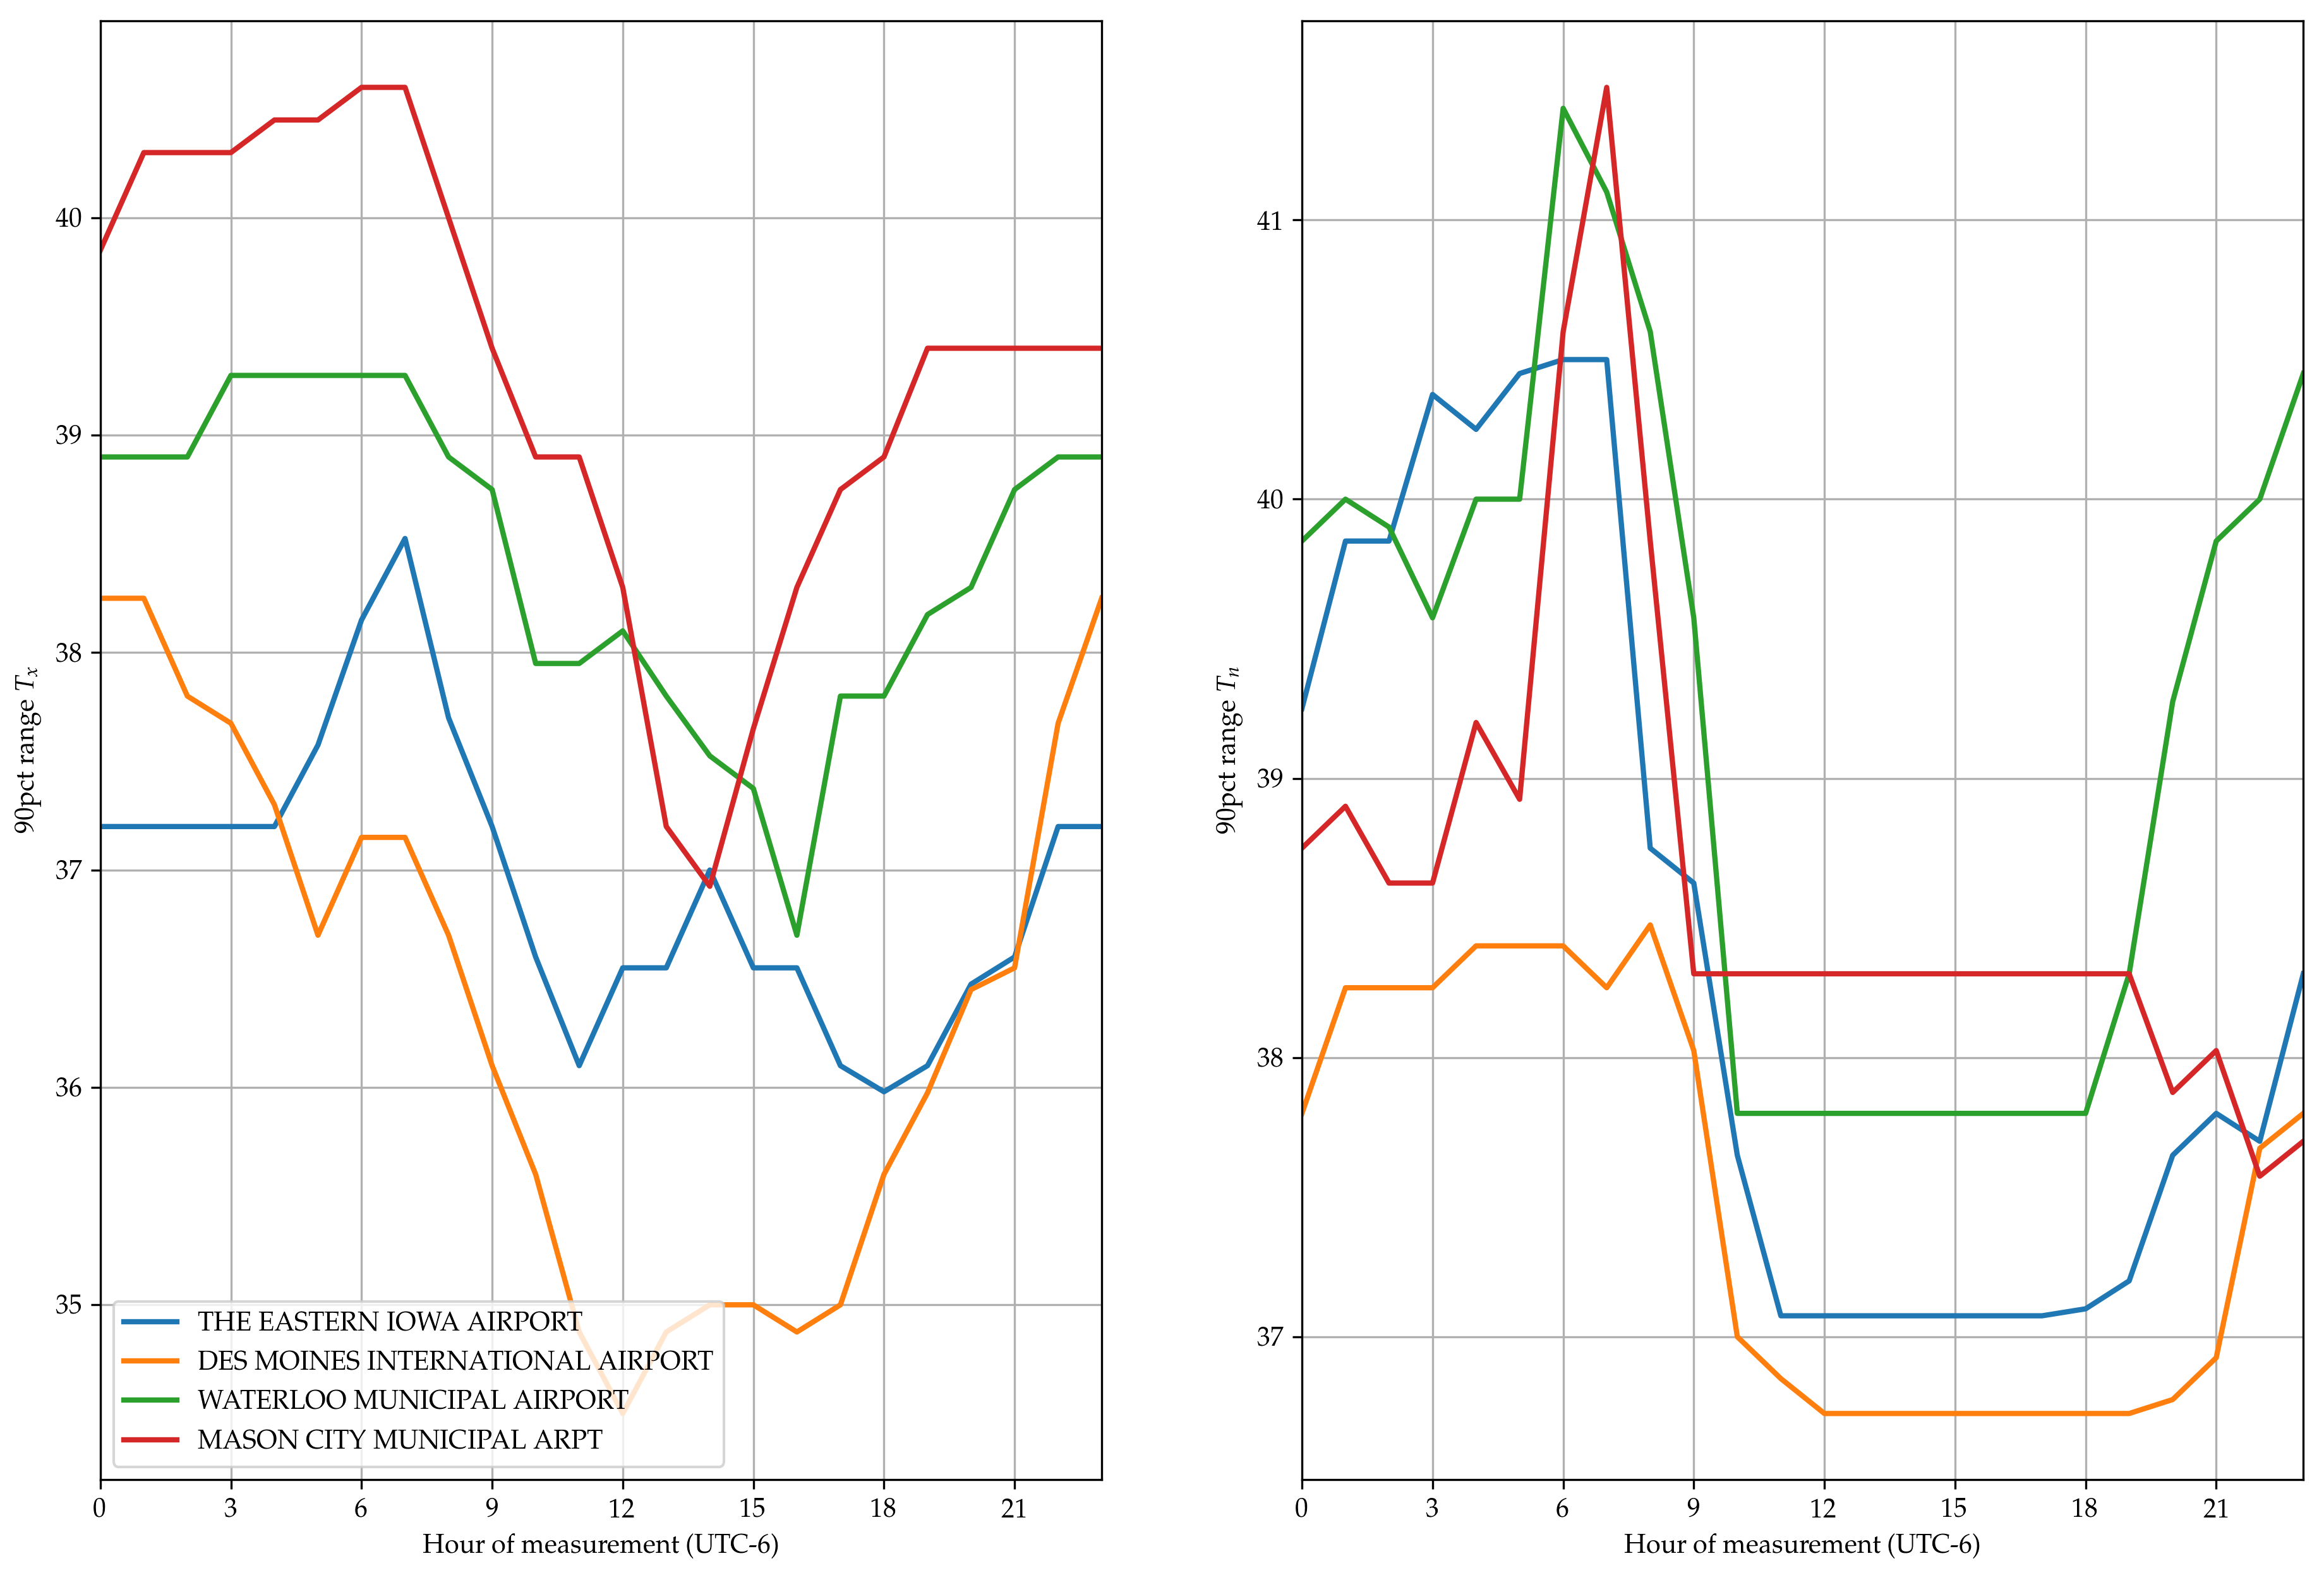

In [17]:
plt.subplot(1,2,1)
hours = Hour(0):Hour(1):Hour(23)
ilocaltime = circshift(1:24, -6)
begin
    statdict = Dict{Int64, Vector{Float64}}(
        1=>Float64[],
        2=>Float64[],
        3=>Float64[],
        4=>Float64[]
        )
    for istation in 1:4
        for hr in hours
            TnTx = TnTx_dict[istation][hr]
            y = TnTx[:Tx]
            perc950 = quantile(y, 0.950)
            perc050 = quantile(y, 0.050)
            push!(statdict[istation], perc950-perc050)
        end
    end

    for station in 1:4
        plt.plot(0:23, statdict[station][ilocaltime], linewidth=2, label=isdSubset[station,:NAME])
    end
    plt.ylabel(L"90pct range $T_x$")
    plt.xlabel("Hour of measurement (UTC-6)")
    plt.grid()
    plt.legend(loc="lower left")
    plt.xticks(0:3:24)
    plt.xlim(0, 23)
end
plt.subplot(1,2,2)
begin
    statdict = Dict{Int64, Vector{Float64}}(
        1=>Float64[],
        2=>Float64[],
        3=>Float64[],
        4=>Float64[]
        )
    for istation in 1:4
        for hr in hours
            TnTx = TnTx_dict[istation][hr]
            y = TnTx[:Tn]
            perc950 = quantile(y, 0.950)
            perc050 = quantile(y, 0.050)
            push!(statdict[istation], perc950-perc050)
        end
    end

    for station in 1:4
        plt.plot(0:23, statdict[station][ilocaltime], linewidth=2)
    end
    plt.ylabel(L"90pct range $T_n$")
    plt.xlabel("Hour of measurement (UTC-6)")
    plt.grid(true)
    plt.xticks(0:3:24)
    plt.xlim(0, 23)
end
plt.gcf()[:set_size_inches](15.0, 10.0)
plt.savefig("../figures/waterloo_90range.png", bbox_inches="tight")
plt.savefig("../figures/waterloo_90range.pdf", bbox_inches="tight")
;

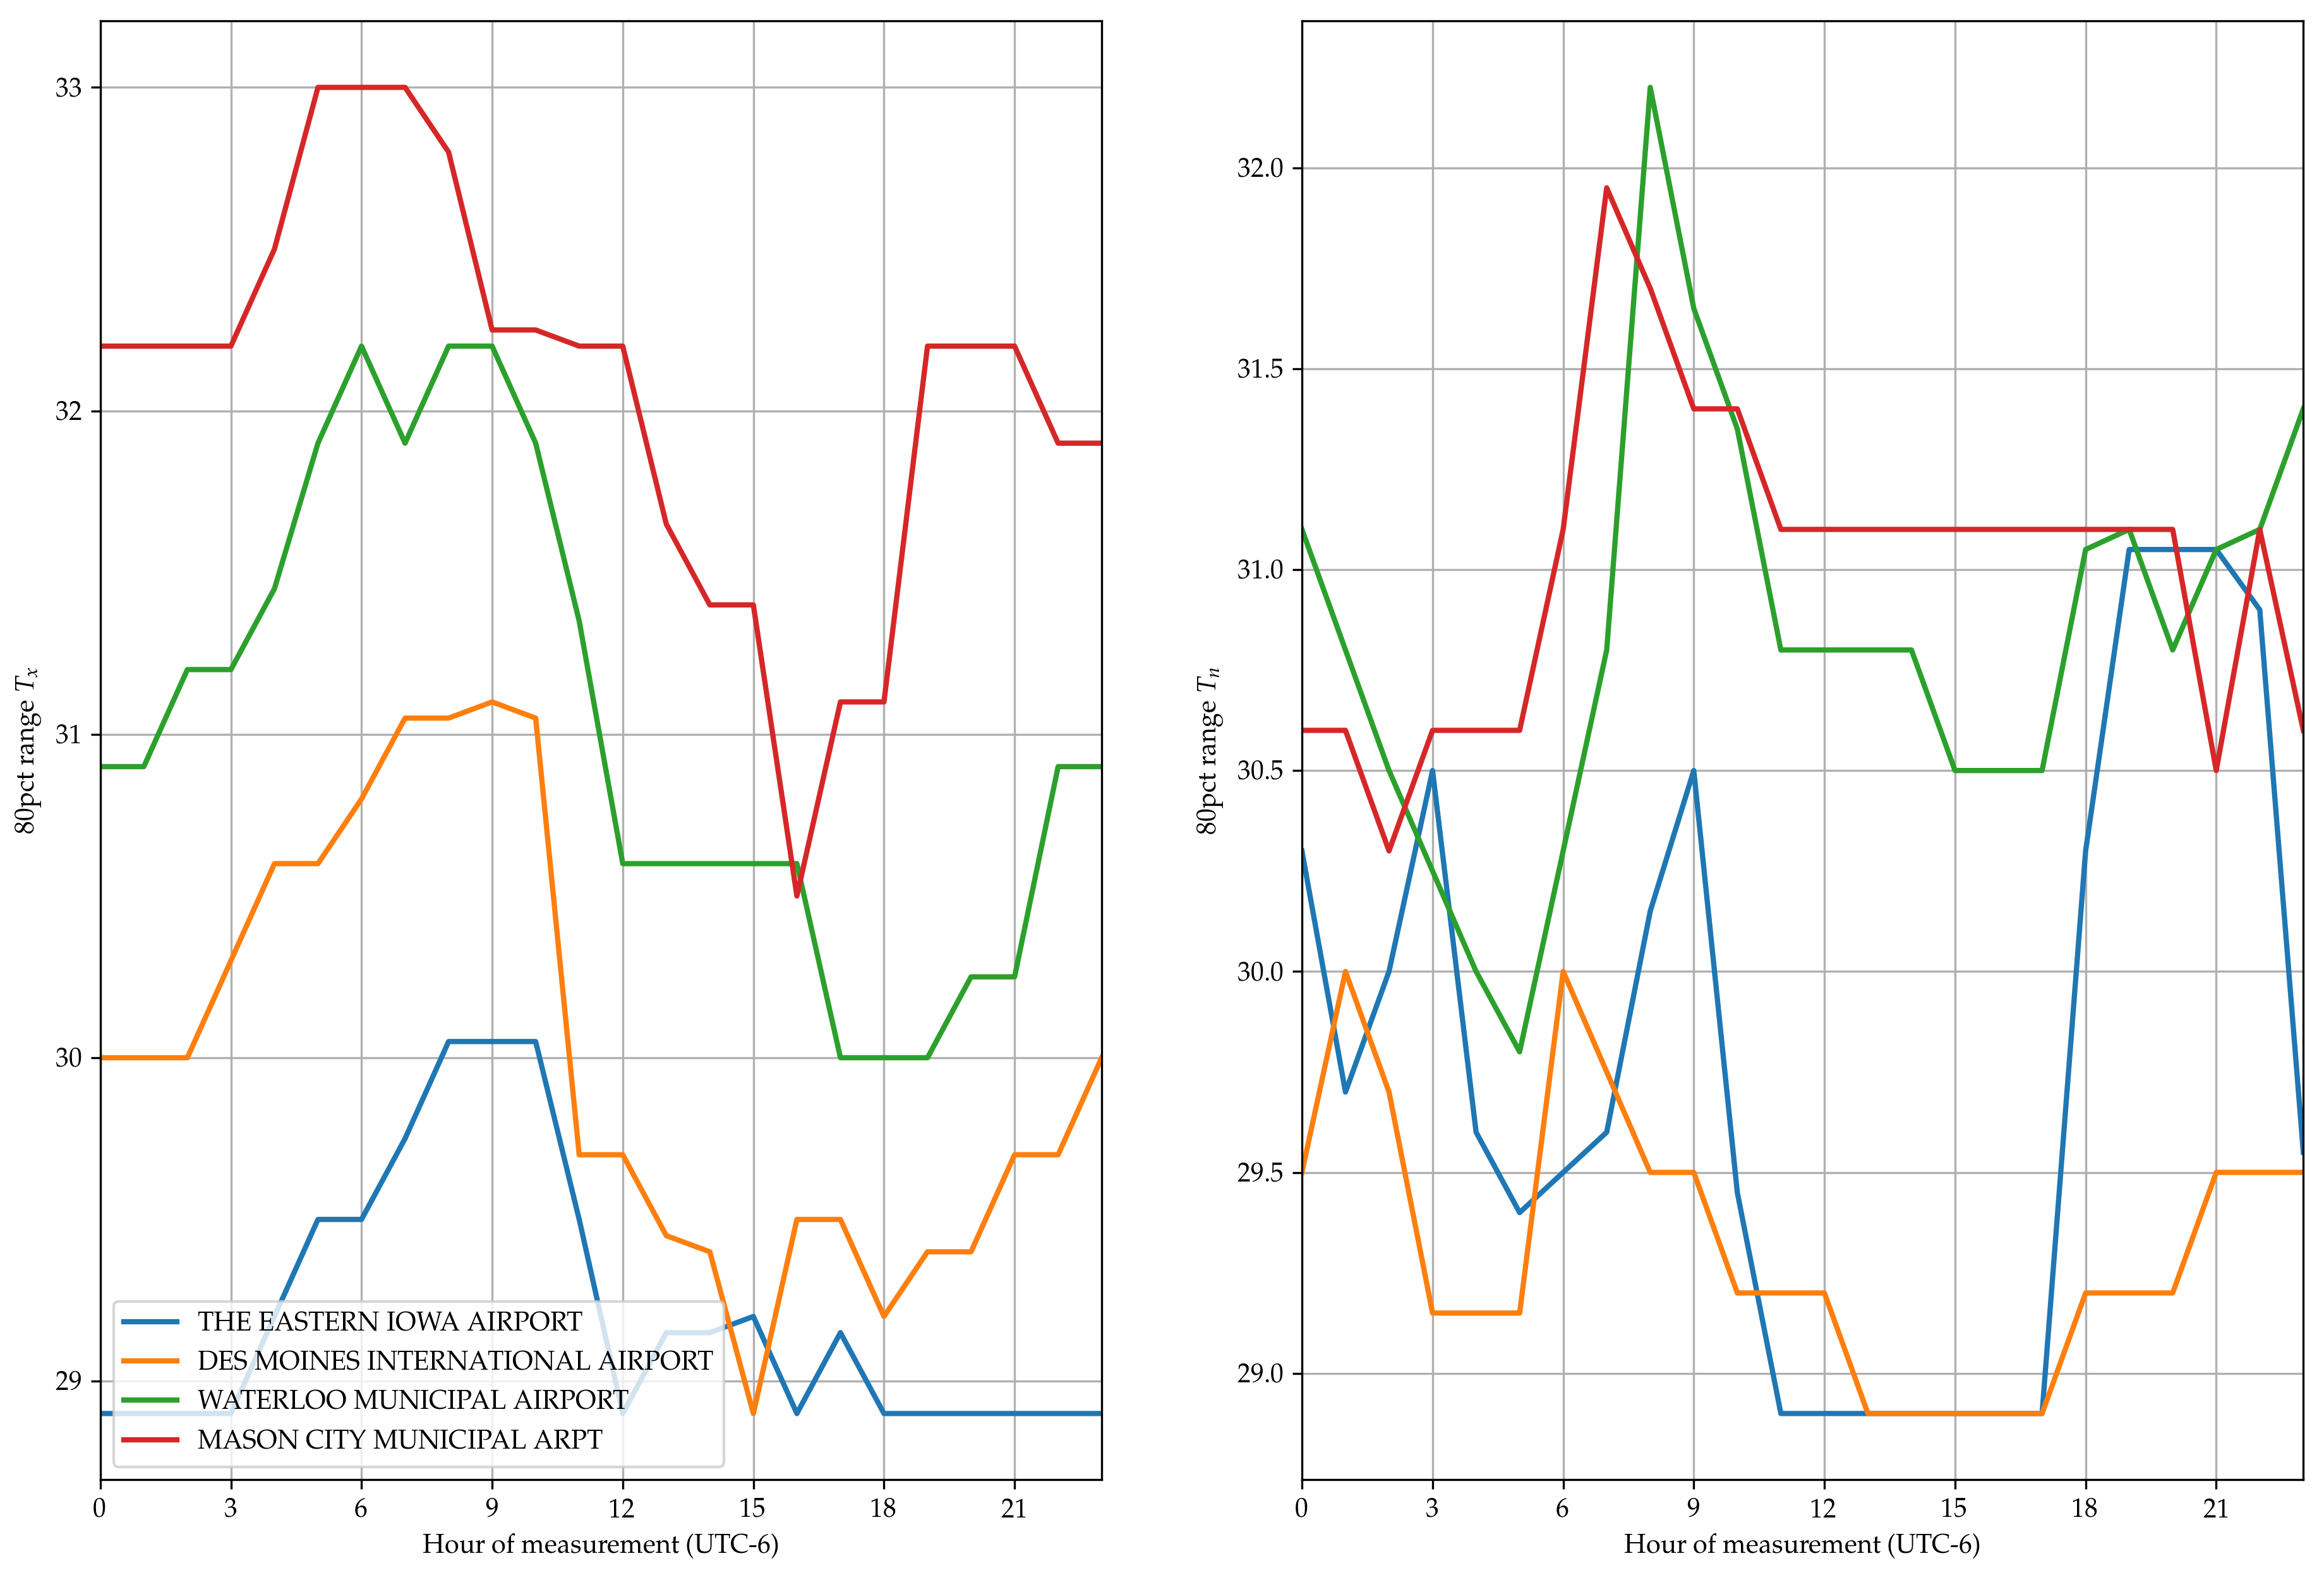

In [18]:
plt.subplot(1,2,1)
hours = Hour(0):Hour(1):Hour(23)
ilocaltime = circshift(1:24, -6)
begin
    statdict = Dict{Int64, Vector{Float64}}(
        1=>Float64[],
        2=>Float64[],
        3=>Float64[],
        4=>Float64[]
        )
    for istation in 1:4
        for hr in hours
            TnTx = TnTx_dict[istation][hr]
            y = TnTx[:Tx]
            perc900 = quantile(y, 0.900)
            perc100 = quantile(y, 0.100)
            push!(statdict[istation], perc900-perc100)
        end
    end

    for station in 1:4
        plt.plot(0:23, statdict[station][ilocaltime], linewidth=2, label=isdSubset[station,:NAME])
    end
    plt.ylabel(L"80pct range $T_x$")
    plt.xlabel("Hour of measurement (UTC-6)")
    plt.grid()
    plt.legend(loc="lower left")
    plt.xticks(0:3:24)
    plt.xlim(0, 23)
end
plt.subplot(1,2,2)
begin
    statdict = Dict{Int64, Vector{Float64}}(
        1=>Float64[],
        2=>Float64[],
        3=>Float64[],
        4=>Float64[]
        )
    for istation in 1:4
        for hr in hours
            TnTx = TnTx_dict[istation][hr]
            y = TnTx[:Tn]
            perc900 = quantile(y, 0.900)
            perc100 = quantile(y, 0.100)
            push!(statdict[istation], perc900-perc100)
        end
    end

    for station in 1:4
        plt.plot(0:23, statdict[station][ilocaltime], linewidth=2)
    end
    plt.ylabel(L"80pct range $T_n$")
    plt.xlabel("Hour of measurement (UTC-6)")
    plt.grid(true)
    plt.xticks(0:3:24)
    plt.xlim(0, 23)
end
plt.gcf()[:set_size_inches](15.0, 10.0)
plt.savefig("../figures/waterloo_80range.png", bbox_inches="tight")
plt.savefig("../figures/waterloo_80range.pdf", bbox_inches="tight")
;